In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asteroidcap4040","key":"347de75c6c5ec37735bb6f394a8f945c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.24G/2.29G [00:20<00:01, 39.7MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s] 


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest_xray_pneumonia

In [ ]:
ls chest_xray_pneumonia/chest_xray

chest_xray  __MACOSX  test  train  val


# **Average Pixel Calculation**


In [ ]:
# Step 1: install (optional) and imports + helper functions
!pip install -q scikit-image

import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure
from scipy import ndimage as ndi

# ---------- helpers ----------
TARGET_SIZE = (512, 512)   # change if you want smaller/faster

def read_gray(path, target_size=TARGET_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img

def preprocess_img(img):
    # CLAHE + slight blur (keeps settings simple & robust)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    img_blur = cv2.GaussianBlur(img_clahe, (5,5), 0)
    return img_blur

def get_lung_mask(img):
    """
    Heuristic lung segmentation:
      - adaptive thresholding (inverted)
      - morphological close/open
      - keep the two largest components, fill holes
    Returns boolean mask same size as img.
    """
    # img should be preprocessed grayscale
    th = cv2.adaptiveThreshold(img, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 15, 7)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=3)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=2)
    opened_bool = opened.astype(bool)
    filled = ndi.binary_fill_holes(opened_bool)
    labeled, n = ndi.label(filled)
    mask = np.zeros_like(img, dtype=bool)
    if n > 0:
        sizes = np.bincount(labeled.ravel())
        # find up to two largest components
        if sizes.size > 1:
            largest = np.argsort(sizes[1:])[::-1][:2] + 1
            for lab in largest:
                mask[labeled == lab] = True
    # final cleanup
    mask = morphology.remove_small_objects(mask, min_size=500)
    mask = ndi.binary_fill_holes(mask)
    return mask


processed 100 / 1341
processed 200 / 1341
processed 300 / 1341
processed 400 / 1341
processed 500 / 1341
processed 600 / 1341
processed 700 / 1341
processed 800 / 1341
processed 900 / 1341
processed 1000 / 1341
processed 1100 / 1341
processed 1200 / 1341
processed 1300 / 1341
Found healthy images: 1341
Saved /content/mean_anatomy.png


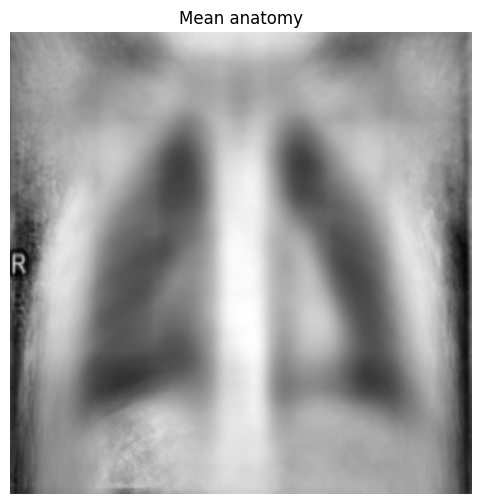

In [ ]:
# Step 2: build mean anatomy map (pixel-wise average inside lung masks)
HEALTHY_DIR = '/content/chest_xray_pneumonia/chest_xray/train/NORMAL'  # <- change to your path
MAX_IMAGES = None   # set to an int while testing to speed up

def build_mean_anatomy(healthy_dir, max_images=None, target_size=TARGET_SIZE):
    # collect image files recursively
    exts = ('*.png','*.jpg','*.jpeg','*.PNG','*.JPG','*.JPEG')
    paths = []
    for e in exts:
        paths += glob.glob(os.path.join(healthy_dir, '**', e), recursive=True)
    if len(paths) == 0:
        raise FileNotFoundError("No healthy images found in: " + healthy_dir)

    sum_img = np.zeros(target_size, dtype=np.float64)
    count = np.zeros(target_size, dtype=np.float64)

    for i, p in enumerate(paths):
        if (max_images is not None) and (i >= max_images):
            break
        img = read_gray(p, target_size)
        img_p = preprocess_img(img)
        mask = get_lung_mask(img_p)
        if mask.sum() == 0:
            continue
        sum_img[mask] += img_p[mask]
        count[mask] += 1
        if (i+1) % 100 == 0:
            print(f"processed {i+1} / {len(paths)}")

    mean_anat = np.zeros_like(sum_img)
    valid = count > 0
    mean_anat[valid] = sum_img[valid] / count[valid]
    mean_anat = np.uint8(np.clip(mean_anat, 0, 255))
    return mean_anat, len(paths)

mean_anat, total_found = build_mean_anatomy(HEALTHY_DIR, max_images=MAX_IMAGES)
print("Found healthy images:", total_found)
plt.figure(figsize=(6,6)); plt.imshow(mean_anat, cmap='gray'); plt.title('Mean anatomy'); plt.axis('off')
# save for later
cv2.imwrite('/content/mean_anatomy.png', mean_anat)
print("Saved /content/mean_anatomy.png")


Infection area: 23.633% of lung area  (threshold=53.78)


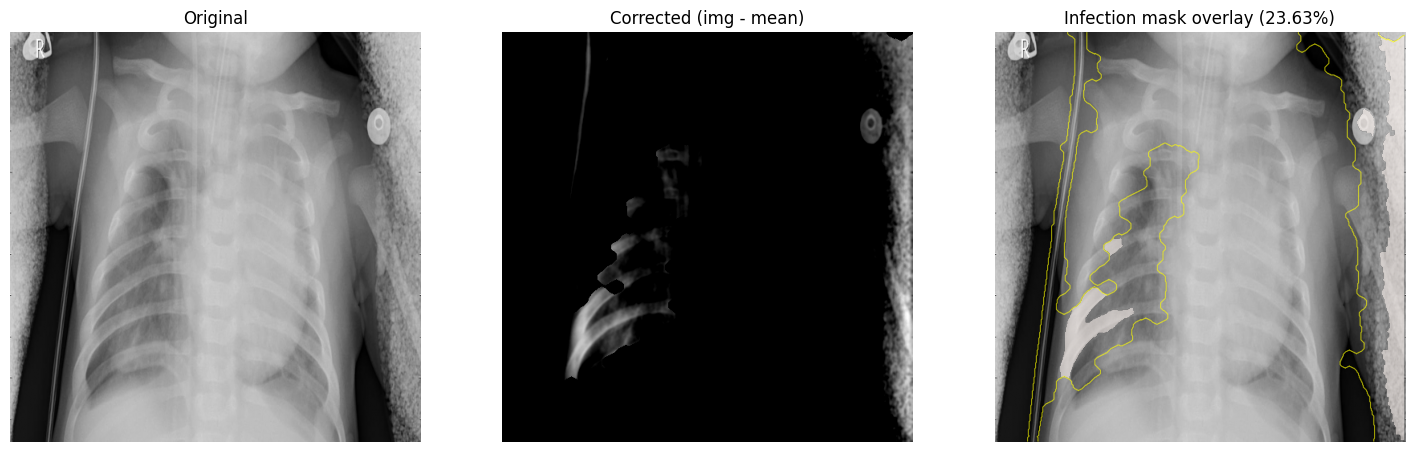

Saved /content/infection_mask.png and /content/corrected.png


In [ ]:
# Step 3: run correction on one infected image
INFECTED_PATH = '/content/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'  # <- change
MIN_OBJECT_SIZE = 300   # tweak as needed

# load
img = read_gray(INFECTED_PATH, TARGET_SIZE)
img_p = preprocess_img(img)
lung_mask = get_lung_mask(img_p)
if lung_mask.sum() == 0:
    raise RuntimeError("Lung mask is empty for this infected image (adjust mask function).")

# mean_anat already computed in Step 2 (same TARGET_SIZE)
mean_map = mean_anat.astype(float)

# corrected = (image - mean_map) inside lung region (we expect pneumonia opacities to be positive)
corrected = img_p.astype(float) - mean_map
corrected[~lung_mask] = 0.0
corrected = np.clip(corrected, 0, 255)

# threshold (Otsu on lung region of corrected image)
vals = corrected[lung_mask]
if vals.size == 0 or vals.std() < 1e-6:
    thresh = np.mean(vals) + 0.5 * np.std(vals)
else:
    thresh = filters.threshold_otsu(vals)

raw_mask = corrected > thresh

# morphological cleanup
clean = morphology.remove_small_objects(raw_mask, min_size=MIN_OBJECT_SIZE)
clean = ndi.binary_closing(clean, structure=np.ones((5,5)))
clean = ndi.binary_fill_holes(clean)
clean = clean & lung_mask  # ensure inside lungs

# infection percentage
infection_percent = 100.0 * (clean.sum() / lung_mask.sum())
print(f"Infection area: {infection_percent:.3f}% of lung area  (threshold={thresh:.2f})")

# visualization
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(img, cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off')
ax[1].imshow(corrected, cmap='gray'); ax[1].set_title('Corrected (img - mean)'); ax[1].axis('off')
ax[2].imshow(img, cmap='gray');
# overlay infection mask in red
ax[2].imshow(np.ma.masked_where(~clean, clean), cmap='Reds', alpha=0.5);
ax[2].contour(lung_mask, colors='yellow', linewidths=0.8, alpha=0.6)
ax[2].set_title(f'Infection mask overlay ({infection_percent:.2f}%)'); ax[2].axis('off')
plt.show()

# optional: save mask and cleaned image
cv2.imwrite('/content/infection_mask.png', (clean.astype(np.uint8)*255))
cv2.imwrite('/content/corrected.png', np.uint8(np.clip(corrected,0,255)))
print("Saved /content/infection_mask.png and /content/corrected.png")


✅ Average pixel intensity (inside lungs): 133.66


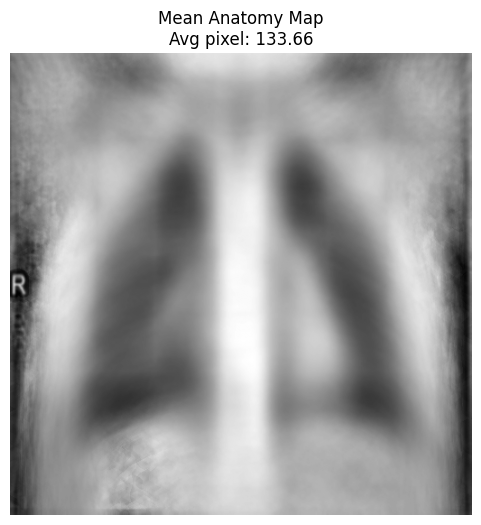

In [ ]:
# --- setup ---
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from scipy import ndimage as ndi

TARGET_SIZE = (512, 512)

def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

def preprocess_img(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return cv2.GaussianBlur(img, (5,5), 0)

def get_lung_mask(img):
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 15, 7)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    filled = ndi.binary_fill_holes(mask.astype(bool))
    labeled, n = ndi.label(filled)
    mask_final = np.zeros_like(img, dtype=bool)
    if n > 0:
        sizes = np.bincount(labeled.ravel())
        largest = np.argsort(sizes[1:])[::-1][:2] + 1
        for lab in largest:
            mask_final[labeled == lab] = True
    mask_final = morphology.remove_small_objects(mask_final, min_size=500)
    return ndi.binary_fill_holes(mask_final)

# --- specify your healthy images folder ---
HEALTHY_DIR = '/content/chest_xray_pneumonia/chest_xray/train/NORMAL'  # adjust as needed

# --- compute mean anatomy ---
paths = glob.glob(os.path.join(HEALTHY_DIR, '**', '*.jpeg'), recursive=True)
sum_img = np.zeros(TARGET_SIZE, dtype=np.float64)
count = np.zeros(TARGET_SIZE, dtype=np.float64)
all_pixel_values = []  # to collect all lung-region pixels

for i, p in enumerate(paths):
    img = read_gray(p)
    img_p = preprocess_img(img)
    mask = get_lung_mask(img_p)
    if mask.sum() == 0:
        continue
    sum_img[mask] += img_p[mask]
    count[mask] += 1
    all_pixel_values.extend(img_p[mask].flatten())

mean_anat = np.zeros_like(sum_img)
valid = count > 0
mean_anat[valid] = sum_img[valid] / count[valid]
mean_anat = np.uint8(np.clip(mean_anat, 0, 255))

# --- calculate average pixel intensity ---
avg_pixel_value = np.mean(all_pixel_values)

print(f"✅ Average pixel intensity (inside lungs): {avg_pixel_value:.2f}")

# --- visualize the mean anatomy map ---
plt.figure(figsize=(6,6))
plt.imshow(mean_anat, cmap='gray')
plt.title(f'Mean Anatomy Map\nAvg pixel: {avg_pixel_value:.2f}')
plt.axis('off')
plt.show()


Without subtraction: 60.038% of lung area  (threshold=127.00)
With subtraction:    20.287% of lung area  (threshold=30.79)


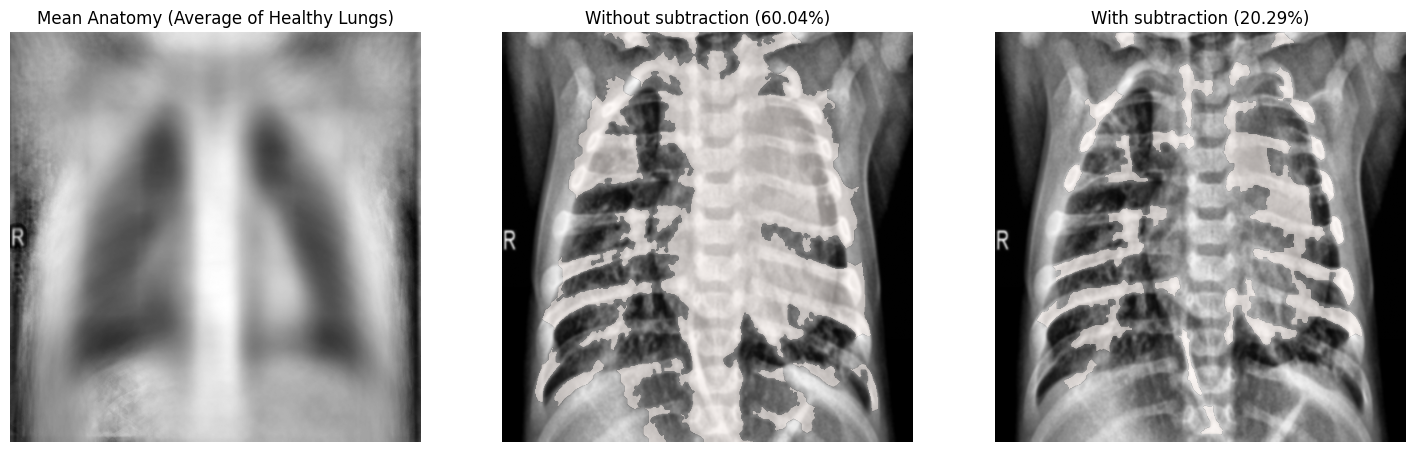

Saved mean_anatomy.png and infection_mask_nosub.png


In [ ]:
# Step 4: Comparison — infection area without subtraction + show mean anatomy

# --- 1️⃣ Without subtraction ---
# We'll run the same thresholding directly on preprocessed image
vals_raw = img_p[lung_mask]
if vals_raw.size == 0 or vals_raw.std() < 1e-6:
    thresh_raw = np.mean(vals_raw) + 0.5 * np.std(vals_raw)
else:
    thresh_raw = filters.threshold_otsu(vals_raw)

raw_infection = img_p > thresh_raw
raw_infection = raw_infection & lung_mask
raw_infection = morphology.remove_small_objects(raw_infection, min_size=MIN_OBJECT_SIZE)
raw_infection = ndi.binary_fill_holes(raw_infection)

infection_percent_raw = 100.0 * (raw_infection.sum() / lung_mask.sum())

print(f"Without subtraction: {infection_percent_raw:.3f}% of lung area  (threshold={thresh_raw:.2f})")
print(f"With subtraction:    {infection_percent:.3f}% of lung area  (threshold={thresh:.2f})")

# --- 2️⃣ Display mean anatomy map and comparison ---
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(mean_anat, cmap='gray')
ax[0].set_title('Mean Anatomy (Average of Healthy Lungs)')
ax[0].axis('off')

ax[1].imshow(img_p, cmap='gray')
ax[1].imshow(np.ma.masked_where(~raw_infection, raw_infection), cmap='Reds', alpha=0.5)
ax[1].set_title(f'Without subtraction ({infection_percent_raw:.2f}%)')
ax[1].axis('off')

ax[2].imshow(img_p, cmap='gray')
ax[2].imshow(np.ma.masked_where(~clean, clean), cmap='Reds', alpha=0.5)
ax[2].set_title(f'With subtraction ({infection_percent:.2f}%)')
ax[2].axis('off')

plt.show()

# optional saves
cv2.imwrite('/content/mean_anatomy.png', mean_anat)
cv2.imwrite('/content/infection_mask_nosub.png', (raw_infection.astype(np.uint8)*255))
print("Saved mean_anatomy.png and infection_mask_nosub.png")


In [ ]:
import pandas as pd
from tqdm import tqdm

# Path to PNEUMONIA test images
TEST_INFECTED_DIR = '/content/chest_xray_pneumonia/chest_xray/test/PNEUMONIA'  # change if needed
RESULTS = []

# Get all images
exts = ('*.png','*.jpg','*.jpeg','*.PNG','*.JPG','*.JPEG')
paths = []
for e in exts:
    paths += glob.glob(os.path.join(TEST_INFECTED_DIR, '**', e), recursive=True)

print(f"Found {len(paths)} pneumonia test images.")

for p in tqdm(paths):
    try:
        img = read_gray(p, TARGET_SIZE)
        img_p = preprocess_img(img)
        lung_mask = get_lung_mask(img_p)
        if lung_mask.sum() == 0:
            continue

        # ---- Without subtraction ----
        vals_raw = img_p[lung_mask]
        if vals_raw.size == 0 or vals_raw.std() < 1e-6:
            thresh_raw = np.mean(vals_raw) + 0.5 * np.std(vals_raw)
        else:
            thresh_raw = filters.threshold_otsu(vals_raw)

        raw_mask = (img_p > thresh_raw) & lung_mask
        raw_mask = morphology.remove_small_objects(raw_mask, min_size=MIN_OBJECT_SIZE)
        raw_mask = ndi.binary_fill_holes(raw_mask)
        infection_raw = 100 * (raw_mask.sum() / lung_mask.sum())

        # ---- With subtraction ----
        corrected = img_p.astype(float) - mean_anat.astype(float)
        corrected[~lung_mask] = 0
        corrected = np.clip(corrected, 0, 255)
        vals_corr = corrected[lung_mask]
        if vals_corr.size == 0 or vals_corr.std() < 1e-6:
            thresh_corr = np.mean(vals_corr) + 0.5 * np.std(vals_corr)
        else:
            thresh_corr = filters.threshold_otsu(vals_corr)

        corr_mask = corrected > thresh_corr
        corr_mask = morphology.remove_small_objects(corr_mask, min_size=MIN_OBJECT_SIZE)
        corr_mask = ndi.binary_fill_holes(corr_mask)
        corr_mask = corr_mask & lung_mask
        infection_corr = 100 * (corr_mask.sum() / lung_mask.sum())

        # save result
        RESULTS.append({
            "filename": os.path.basename(p),
            "infection_raw(%)": infection_raw,
            "infection_corrected(%)": infection_corr
        })

    except Exception as e:
        print(f"⚠️ Skipped {p}: {e}")

# Convert to DataFrame
df_results = pd.DataFrame(RESULTS)
print(f"Processed {len(df_results)} valid images.")


Found 390 pneumonia test images.


100%|██████████| 390/390 [00:27<00:00, 13.98it/s]

Processed 390 valid images.


In [ ]:
df_results.head(30)

,filename,infection_raw(%),infection_corrected(%)
0,person111_bacteria_536.jpeg,53.427864,29.672183
1,person101_bacteria_484.jpeg,55.461746,28.247469
2,person82_bacteria_402.jpeg,45.387518,18.875963
3,person91_bacteria_447.jpeg,42.129874,18.205907
4,person111_bacteria_534.jpeg,51.037142,17.137244
5,person85_bacteria_419.jpeg,42.643500,13.403984
6,person1622_virus_2810.jpeg,32.526966,18.814712
7,person139_bacteria_663.jpeg,51.271329,8.422366
8,person21_virus_53.jpeg,50.967509,26.165962
9,person1637_virus_2834.jpeg,50.153041,23.144874


In [ ]:
print("Average infection percentage:")
print(df_results[['infection_raw(%)', 'infection_corrected(%)']].mean())

# Save for later
df_results.to_csv('/content/pneumonia_infection_comparison.csv', index=False)
print("Saved to /content/pneumonia_infection_comparison.csv")


Average infection percentage:
infection_raw(%)          48.891876
infection_corrected(%)    22.762343
dtype: float64
Saved to /content/pneumonia_infection_comparison.csv


# **Pneumonia Detection**

# VGG-19

In [ ]:
# ==============================
# STEP 1: Import Libraries
# ==============================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# ==============================
# STEP 2: Set Paths
# ==============================
train_dir = "/content/chest_xray_pneumonia/chest_xray/train"
val_dir = "/content/chest_xray_pneumonia/chest_xray/val"
test_dir = "/content/chest_xray_pneumonia/chest_xray/test"

In [ ]:
# ==============================
# STEP 3: Data Preprocessing
# ==============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:

# ==============================
# STEP 4: Load Pretrained VGG19
# ==============================
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

# ==============================
# STEP 5: Build the Model
# ==============================
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,235,905 (88.64 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# ==============================
# STEP 6: Train the Model
# ==============================
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 703ms/step - accuracy: 0.8136 - loss: 0.4843 - val_accuracy: 0.8125 - val_loss: 0.4592
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 655ms/step - accuracy: 0.9243 - loss: 0.1926 - val_accuracy: 0.7500 - val_loss: 0.6380
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 647ms/step - accuracy: 0.9319 - loss: 0.1683 - val_accuracy: 0.8125 - val_loss: 0.3970
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9465 - loss: 0.1500 - val_accuracy: 0.8750 - val_loss: 0.2554
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 653ms/step - accuracy: 0.9450 - loss: 0.1389 - val_accuracy: 0.8125 - val_loss: 0.4933
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9495 - loss: 0.1407 - val_accuracy: 0.8125 - val_loss: 0.3619
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9527 - loss: 0.1335 - val_accuracy: 0.8125 - val_loss: 0.3218
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9550 -

In [ ]:
# ==============================
# STEP 7: Evaluate on Test Set
# ==============================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.8851 - loss: 0.3928

✅ Test Accuracy: 0.9167


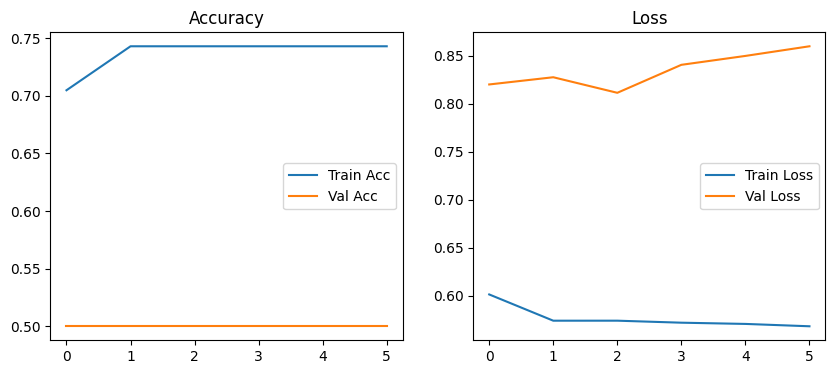

In [ ]:
# ==============================
# STEP 8: Plot Training Curves
# ==============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


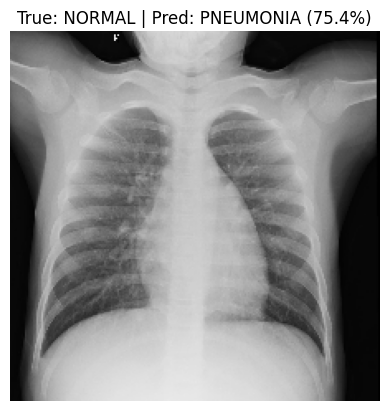

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


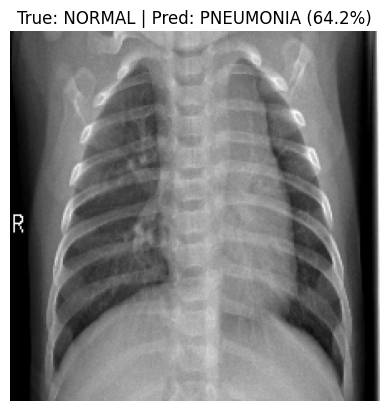

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


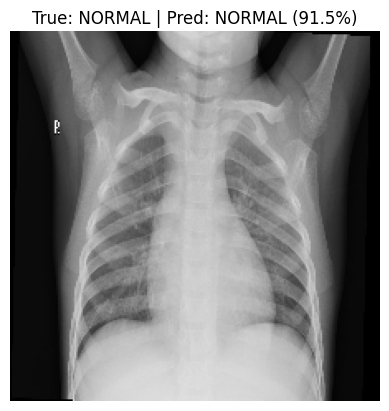

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


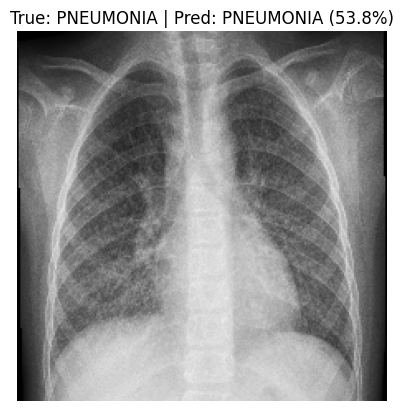

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


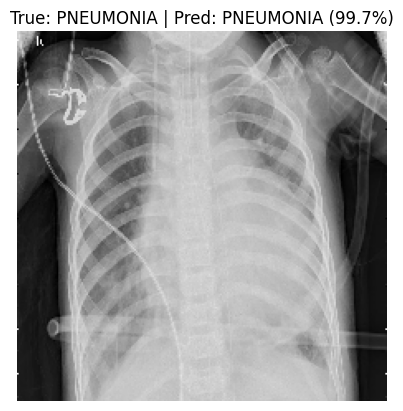

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


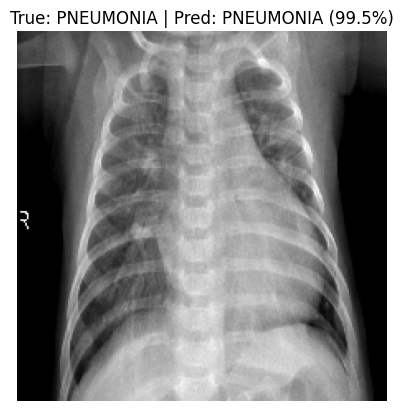

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image

# Paths to test folders
normal_path = os.path.join(test_dir, "NORMAL")
pneumonia_path = os.path.join(test_dir, "PNEUMONIA")

# Randomly select few images from test set
sample_normal = random.sample(os.listdir(normal_path), 3)
sample_pneumonia = random.sample(os.listdir(pneumonia_path), 3)

sample_images = [(os.path.join(normal_path, img), "NORMAL") for img in sample_normal] + \
                [(os.path.join(pneumonia_path, img), "PNEUMONIA") for img in sample_pneumonia]

# Predict and visualize
for img_path, true_label in sample_images:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    pred_label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    confidence = prediction if prediction > 0.5 else (1 - prediction)

    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_label} ({confidence*100:.1f}%)")
    plt.axis("off")
    plt.show()


Save

In [ ]:
model.save("vgg19_pneumonia_model.h5")

In [ ]:
model.save("vgg19_pneumonia_model.keras")

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


# **ResNet152**

In [ ]:
# ==============================
# STEP 1: Import Libraries
# ==============================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# ==============================
# STEP 3: Data Preprocessing
# ==============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# ==============================
# STEP 4: Load Pretrained ResNet152
# ==============================
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers (for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# ==============================
# STEP 5: Build Custom Model
# ==============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 7, 7, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,895,745 (224.67 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [ ]:
# ==============================
# STEP 6: Initial Training
# ==============================
initial_epochs = 30
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 703ms/step - accuracy: 0.6591 - loss: 0.6638 - val_accuracy: 0.5000 - val_loss: 0.8771
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 647ms/step - accuracy: 0.7351 - loss: 0.5830 - val_accuracy: 0.5000 - val_loss: 0.8085
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.7420 - loss: 0.5504 - val_accuracy: 0.5000 - val_loss: 0.8384
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.7549 - loss: 0.5177 - val_accuracy: 0.5000 - val_loss: 0.7436
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.7422 - loss: 0.5189 - val_accuracy: 0.5000 - val_loss: 0.8260
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 640ms/step - accuracy: 0.7424 - loss: 0.5030 - val_accuracy: 0.5000 - val_loss: 0.7632
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.7504 - loss: 0.4983 - val_accuracy: 0.5000 - val_loss: 0.8017
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - accuracy: 0.7540 -

In [ ]:
# ==============================
# STEP 7: Evaluate on Test Set
# ==============================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ ResNet152 Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.5536 - loss: 0.7415

✅ ResNet152 Test Accuracy: 0.7388


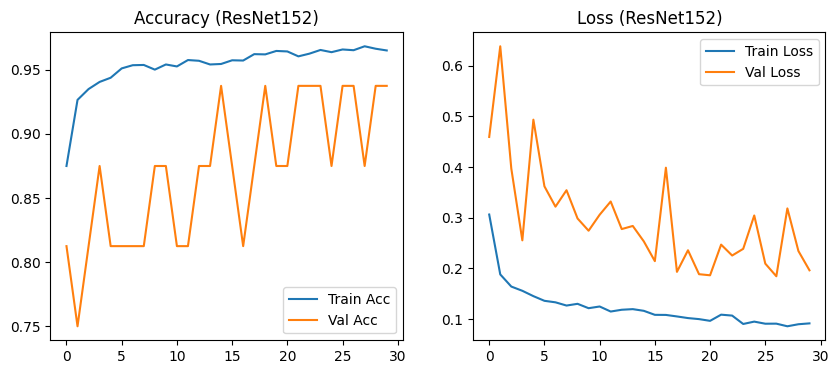

In [ ]:
# ==============================
# STEP 8: Plot Accuracy and Loss
# ==============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy (ResNet152)')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss (ResNet152)')
plt.show()

In [ ]:
# ==============================
# STEP 9: Save Model
# ==============================
model.save("resnet152_pneumonia_model.h5")

In [ ]:
# ==============================
# STEP 9: Save Model
# ==============================
model.save("resnet152_pneumonia_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


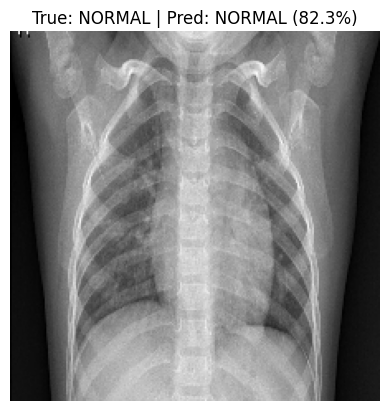

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


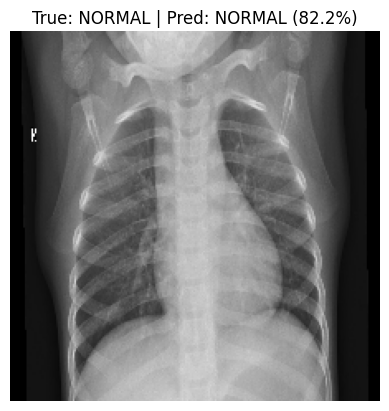

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


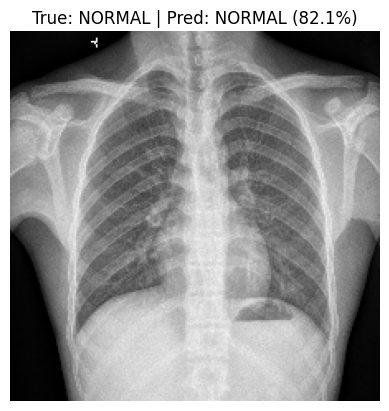

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


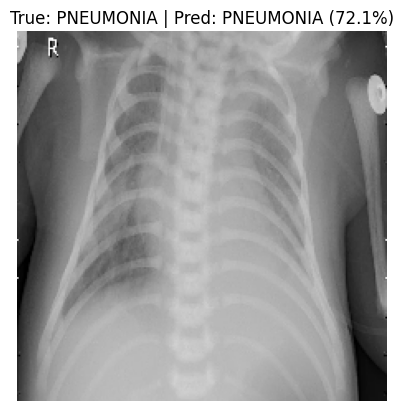

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


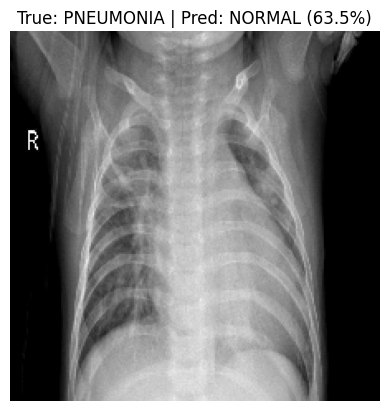

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


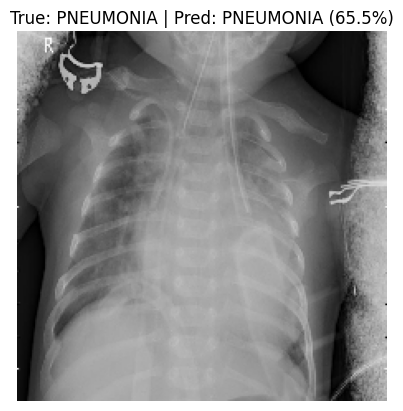

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image

# Make sure you have your test folder paths set
normal_path = os.path.join(test_dir, "NORMAL")
pneumonia_path = os.path.join(test_dir, "PNEUMONIA")

# Randomly select 3 images from each class
sample_normal = random.sample(os.listdir(normal_path), 3)
sample_pneumonia = random.sample(os.listdir(pneumonia_path), 3)

sample_images = [(os.path.join(normal_path, img), "NORMAL") for img in sample_normal] + \
                [(os.path.join(pneumonia_path, img), "PNEUMONIA") for img in sample_pneumonia]

# Predict and visualize
for img_path, true_label in sample_images:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    pred_label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    confidence = prediction if prediction > 0.5 else (1 - prediction)

    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_label} ({confidence*100:.1f}%)")
    plt.axis("off")
    plt.show()


# **DesneNet121**

In [ ]:
# ==============================
# STEP 1: Import Libraries
# ==============================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# ==============================
# STEP 3: Data Preprocessing
# ==============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# ==============================
# STEP 4: Load Pretrained DenseNet121
# ==============================
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all base layers
for layer in base_model.layers:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ==============================
# STEP 5: Add Custom Classification Layers
# ==============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [ ]:
# ==============================
# STEP 6: Compile the Model
# ==============================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# ==============================
# STEP 7: Train the Model
# ==============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 678ms/step - accuracy: 0.7255 - loss: 0.5730 - val_accuracy: 0.7500 - val_loss: 0.4356
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.8995 - loss: 0.2537 - val_accuracy: 0.7500 - val_loss: 0.4220
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9186 - loss: 0.2101 - val_accuracy: 0.8125 - val_loss: 0.3709
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.9277 - loss: 0.1874 - val_accuracy: 0.8750 - val_loss: 0.3697
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - accuracy: 0.9406 - loss: 0.1608 - val_accuracy: 0.8750 - val_loss: 0.3498
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9368 - loss: 0.1701 - val_accuracy: 0.8125 - val_loss: 0.3478
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 595ms/step - accuracy: 0.9391 - loss: 0.1601 - val_accuracy: 0.8125 - val_loss: 0.3336
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 594ms/step - accuracy: 0.9467 - loss: 

In [ ]:
# ==============================
# STEP 8: Evaluate on Test Set
# ==============================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ DenseNet121 Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.8575 - loss: 0.4323

✅ DenseNet121 Test Accuracy: 0.9038


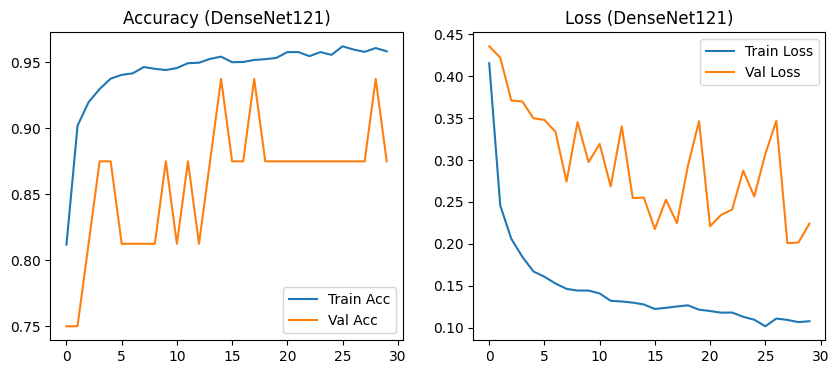

In [ ]:
# ==============================
# STEP 9: Plot Accuracy & Loss
# ==============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy (DenseNet121)')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss (DenseNet121)')
plt.show()

In [ ]:
# ==============================
# STEP 10: Save Model
# ==============================
model.save("densenet121_pneumonia_model.keras")

In [ ]:
# ==============================
# STEP 10: Save Model
# ==============================
model.save("densenet121_pneumonia_model.h5")

# **EfficientNetB3**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Image dimensions (EfficientNetB3 expects 300x300)
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load EfficientNetB3 base model
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # freeze base for transfer learning

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    "best_efficientnet_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.6337 - loss: 0.6390
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_efficientnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 974ms/step - accuracy: 0.6342 - loss: 0.6387 - val_accuracy: 0.5000 - val_loss: 0.8202
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7514 - loss: 0.5646
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 861ms/step - accuracy: 0.7513 - loss: 0.5647 - val_accuracy: 0.5000 - val_loss: 0.8277
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7466 - loss: 0.5706
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 859ms/step - accuracy: 0.7466 - loss: 0.5706 - val_accuracy: 0.5000 - val_loss: 0.8115
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.7420 - loss: 0.5739
Epoch 4: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 852ms/step - accuracy: 0.7420 - loss: 0.5739 - val_accuracy: 0.5000 - val_loss: 0.8406
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7382 - loss: 0.5775
Epoch 5: va

In [ ]:
# Save final model (optional)
model.save("efficientnet_final_model.h5")